In [13]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
import pandas as pd
import wandb
import numpy as np

In [14]:
def PositionalEncoding(sequence_len, output_dim, n=10000):

    P = torch.zeros((sequence_len, output_dim))

    for k in range(sequence_len):
        for i in range(0, output_dim, 2):  # Increment by 2 to handle both sine and cosine parts
            denominator = torch.tensor(n, dtype=torch.float).pow(2 * i / output_dim)
            P[k, i] = torch.sin(k / denominator)
            P[k, i + 1] = torch.cos(k / denominator)
            
    return P

In [15]:
class PatchEmbedding(nn.Module):
    def __init__(self, img_size, patch_size, in_channels, embed_dim, device='cpu'):
        super().__init__()

        self.img_size = img_size
        self.patch_size = patch_size

        self.n_patches = (img_size // patch_size) * (img_size // patch_size)

        self.patch_embedding = nn.Sequential(
            nn.Conv2d(in_channels, (embed_dim // 2), kernel_size=patch_size, stride=patch_size),
            nn.Flatten(1)
        )
        
        self.pos_encoding = PositionalEncoding(sequence_len=self.n_patches, output_dim=(embed_dim // 2), n=1000).to(device)

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))

    def forward(self, x):
        B, C, H, W = x.shape

        x = self.patch_embedding(x)

        x = x.view(B, self.n_patches, -1)

        cls_tokens = self.cls_token.expand(B, -1, -1)
        
        x = torch.cat([self.pos_encoding.expand(B, -1, -1), x], dim=2)
        
        x = torch.cat([cls_tokens, x], dim=1)

        return x

In [16]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()

        self.embed_dim = embed_dim
        self.num_heads = num_heads

        self.head_dim = embed_dim // num_heads

        self.qkv_proj = nn.Linear(embed_dim, embed_dim * 3)

        self.att_drop = nn.Dropout(0.1)

        self.proj = nn.Linear(embed_dim, embed_dim)

    def forward(self, x):
        B, N, E = x.shape

        qkv = self.qkv_proj(x)

        qkv = qkv.view(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = (q @ k.transpose(-2, -1)) 
        
        attn *= (self.head_dim ** -0.5)

        attn = nn.functional.softmax(attn, dim=-1)

        attn = self.att_drop(attn)

        x = (attn @ v).transpose(1, 2).contiguous().view(B, N, E)

        x = self.proj(x)

        return x

In [17]:
class TransformerEncoder(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_dim):
        super().__init__()

        self.attention = MultiHeadSelfAttention(embed_dim, num_heads)

        self.norm1 = nn.LayerNorm(embed_dim)

        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_dim),
            nn.GELU(),
            nn.Linear(mlp_dim, embed_dim)
        )

        self.norm2 = nn.LayerNorm(embed_dim)

        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        attn_out = self.attention(x)

        x = x + self.dropout(attn_out)
        x = self.norm1(x)

        mlp_out = self.mlp(x)

        x = x + self.dropout(mlp_out)
        x = self.norm2(x)

        return x

In [18]:
class VisionTransformer(nn.Module):
    def __init__(self, img_size, patch_size, in_channels, embed_dim, num_heads, mlp_dim, num_layers, num_classes, device):
        super().__init__()

        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim, device)

        self.transformer_encoders = nn.Sequential(
            *[TransformerEncoder(embed_dim, num_heads, mlp_dim) for _ in range(num_layers)]
        )

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))

        self.norm = nn.LayerNorm(embed_dim)

        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.patch_embed(x)

        x = self.transformer_encoders(x)

        cls_token = x[:, 0]

        cls_token = self.norm(cls_token)

        logits = self.head(cls_token)

        return logits


In [19]:

signmnist_train = pd.read_csv(r"/home/cassanova/Documents/sign language classification/Pytorch-Sign-Language-Detection_CURRENT/Data/sign_mnist_train.csv")
signmnist_test = pd.read_csv(r"/home/cassanova/Documents/sign language classification/Pytorch-Sign-Language-Detection_CURRENT/Data/sign_mnist_test.csv")
train_data, val_data = np.split(signmnist_train.sample(frac=1, random_state=42), [int(0.8 * len(signmnist_train))])

/home/cassanova/miniconda3/envs/signlanguage/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [20]:
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
class Signlanguagedataset(Dataset):
    def __init__(self, data):

        
        
        self.signs_lang_dataset = data
        
        # if self.train == True:
        #     self.signs_lang_dataset = signmnist_train
        # else:
        #     self.signs_lang_dataset = signmnist_test

        self.X_set = self.signs_lang_dataset.iloc[:, 1:].values
        self.y_set = self.signs_lang_dataset.iloc[:, 0].values

        self.X_set = np.reshape(self.X_set, (self.X_set.shape[0], 1, 28, 28)) / 255
        self.y_set = np.array(self.y_set)

    def __getitem__(self, index):

        image = self.X_set[index, :, :]

        label = self.y_set[index]

        sample = {'image_sign': image, 'label': label}

        return sample

    def __len__(self):
        return self.X_set.__len__()

train_dataset = Signlanguagedataset(train_data)
val_dataset = Signlanguagedataset(val_data)
test_dataset = Signlanguagedataset(signmnist_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, pin_memory=True)
test_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, pin_memory=True)

# Create Transformer and Training Tooling

Here we will create the instance of the transformer and the training tools we will use later to train it to the dataset 

In [21]:
device = "cpu"
model = VisionTransformer(
    img_size=28,
    patch_size=7,
    in_channels=1,
    embed_dim=64,
    num_heads=8,
    mlp_dim=64,
    num_layers=12,
    num_classes=25,
    device=device
).to(device)


In [22]:

model

VisionTransformer(
  (patch_embed): PatchEmbedding(
    (patch_embedding): Sequential(
      (0): Conv2d(1, 32, kernel_size=(7, 7), stride=(7, 7))
      (1): Flatten(start_dim=1, end_dim=-1)
    )
  )
  (transformer_encoders): Sequential(
    (0): TransformerEncoder(
      (attention): MultiHeadSelfAttention(
        (qkv_proj): Linear(in_features=64, out_features=192, bias=True)
        (att_drop): Dropout(p=0.1, inplace=False)
        (proj): Linear(in_features=64, out_features=64, bias=True)
      )
      (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (mlp): Sequential(
        (0): Linear(in_features=64, out_features=64, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=64, out_features=64, bias=True)
      )
      (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerEncoder(
      (attention): MultiHeadSelfAttention(
        (qkv_proj): Linear(in_fe

In [23]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)

306073


In [24]:
learning_rate = 3e-4
num_epochs = 48

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
run = wandb.init(
project="SignlanguageVit",    # Specify your project
config={                         # Track hyperparameters and metadata
    "learning_rate": learning_rate,
    "epochs": num_epochs,
    },
)
def train(model, optimizer, epoch, device, train_loader, log_interval):
 
    model.train()
    for batch_idx, data in enumerate(train_loader):

        img = data['image_sign']
        img = img.type(torch.FloatTensor).to(device)
        
        target = data['label']
        target = target.type(torch.LongTensor).to(device)
        
        optimizer.zero_grad()

        output = model(img)
        loss = criterion(output, target)

        loss.backward()
        optimizer.step()
        wandb.log({ "train loss": loss})
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(img), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), loss.item()))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for batch_idx, data in enumerate(test_loader):
            img = data['image_sign']
            img = img.type(torch.FloatTensor).to(device)
            target = data['label']
            target = target.type(torch.LongTensor).to(device)

            output = model(img)
            test_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.max(1, keepdim=True)[1]  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_acc = 100. * correct / len(test_loader.dataset)
    test_loss /= len(test_loader.dataset)
    print('\nVal set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    wandb.log({"validation loss": test_loss, "validation accuracy" : test_acc })

for epoch in range(1, num_epochs + 1):

    train(model, optimizer, epoch, device, train_loader,log_interval=120)
    test(model, device, val_loader)


Train Epoch: 1 [0/21964 (0%)]	Loss: 3.390646
Train Epoch: 1 [3840/21964 (17%)]	Loss: 3.214048
Train Epoch: 1 [7680/21964 (35%)]	Loss: 3.055335
Train Epoch: 1 [11520/21964 (52%)]	Loss: 2.160221
Train Epoch: 1 [15360/21964 (70%)]	Loss: 1.906125
Train Epoch: 1 [19200/21964 (87%)]	Loss: 1.413190

Val set: Average loss: 0.0401, Accuracy: 3431/5491 (62%)

Train Epoch: 2 [0/21964 (0%)]	Loss: 1.237474
Train Epoch: 2 [3840/21964 (17%)]	Loss: 0.885634
Train Epoch: 2 [7680/21964 (35%)]	Loss: 0.913604
Train Epoch: 2 [11520/21964 (52%)]	Loss: 0.839122
Train Epoch: 2 [15360/21964 (70%)]	Loss: 0.650467
Train Epoch: 2 [19200/21964 (87%)]	Loss: 0.722586

Val set: Average loss: 0.0127, Accuracy: 4790/5491 (87%)

Train Epoch: 3 [0/21964 (0%)]	Loss: 0.358954
Train Epoch: 3 [3840/21964 (17%)]	Loss: 0.540439
Train Epoch: 3 [7680/21964 (35%)]	Loss: 0.385934
Train Epoch: 3 [11520/21964 (52%)]	Loss: 0.171404
Train Epoch: 3 [15360/21964 (70%)]	Loss: 0.196872
Train Epoch: 3 [19200/21964 (87%)]	Loss: 0.176655

Va

In [25]:
torch.save(model.state_dict(), r"/home/cassanova/Documents/sign language classification/Pytorch-Sign-Language-Detection_CURRENT/weights/model_Vit_submission")

In [26]:
from sklearn.metrics import classification_report
import seaborn as sn
import pandas as pd
import torch

data = signmnist_test.iloc[:,1:].values.reshape(signmnist_test.shape[0],1,28,28)
data = torch.Tensor(data).to(device)
y_true = signmnist_test.iloc[:,0].values.reshape(signmnist_test.shape[0],1).squeeze()
y_pred_tensor = model(data)
y_pred = y_pred_tensor.cpu().detach().numpy()
y_pred = np.argmax(y_pred,axis=1)
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.66      0.88      0.76       331
           1       1.00      0.94      0.97       432
           2       0.54      1.00      0.70       310
           3       0.93      0.26      0.40       245
           4       0.84      0.45      0.59       498
           5       0.70      0.70      0.70       247
           6       0.66      0.82      0.73       348
           7       0.89      0.82      0.85       436
           8       1.00      0.38      0.55       288
          10       0.75      0.49      0.59       331
          11       1.00      0.62      0.76       209
          12       1.00      0.39      0.56       394
          13       0.39      0.44      0.41       291
          14       0.25      0.93      0.39       246
          15       0.96      0.39      0.56       347
          16       0.52      0.74      0.61       164
          17       0.51      0.28      0.36       144
          18       0.33    

<Axes: >

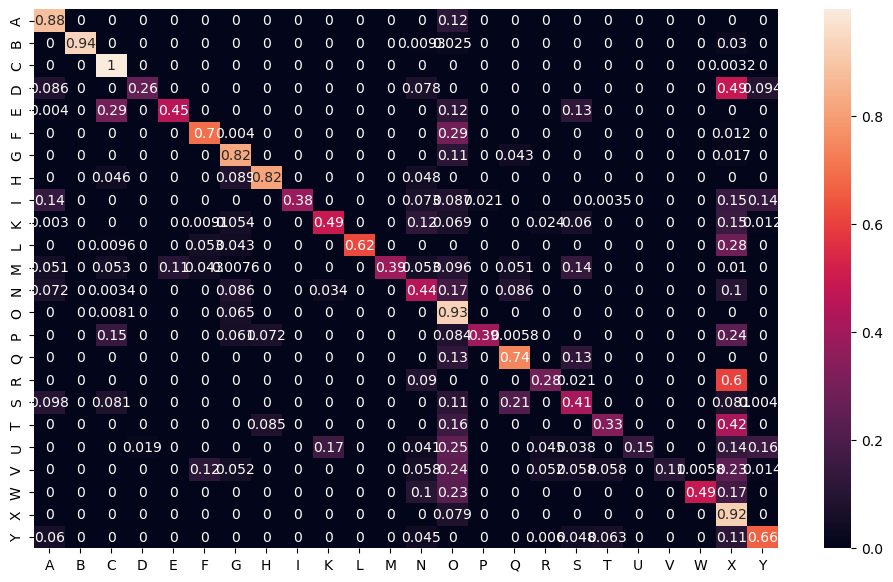

In [27]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
# Build confusion matrix
signs = {'0': 'A', '1': 'B', '2': 'C', '3': 'D', '4': 'E', '5': 'F',
         '6': 'G', '7': 'H', '8': 'I', '10': 'K', '11': 'L', '12': 'M',
         '13': 'N', '14': 'O', '15': 'P', '16': 'Q', '17': 'R', '18': 'S',
         '19': 'T', '20': 'U', '21': 'V', '22': 'W', '23': 'X', '24': 'Y' }
lst = signs.values()
lst = list(lst)
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index=[i for i in lst],
                        columns=[i for i in lst])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)

In [ ]:
import numpy as np
import cv2
import torch

#from Model.network import Net

cap = cv2.VideoCapture(0)

cap.set(3, 700)
cap.set(4, 480)

device = "cpu"
model=VisionTransformer(
    img_size=28,
    patch_size=8,
    in_channels=1,
    embed_dim=64,
    num_heads=4,
    mlp_dim=128,
    num_layers=6,
    num_classes=25,
    device=device
)
model.to(device)
# if torch.cuda.is_available():
checkpoint = r"/home/cassanova/Documents/sign language classification/Pytorch-Sign-Language-Detection_CURRENT/weights/model_Vit_v2"
checkpoints=torch.load(checkpoint)
try:
    checkpoints.eval()
except AttributeError as error:
    print(error)

model.load_state_dict(checkpoints)
model.eval()

signs = {'0': 'A', '1': 'B', '2': 'C', '3': 'D', '4': 'E', '5': 'F', '6': 'G', '7': 'H', '8': 'I',
        '10': 'K', '11': 'L', '12': 'M', '13': 'N', '14': 'O', '15': 'P', '16': 'Q', '17': 'R',
        '18': 'S', '19': 'T', '20': 'U', '21': 'V', '22': 'W', '23': 'X', '24': 'Y' }
while True:
    ret, frame = cap.read()
    img = frame[100:250, 100:250]

    res = cv2.resize(img, dsize=(28, 28), interpolation = cv2.INTER_CUBIC)
    res = cv2.cvtColor(res, cv2.COLOR_BGR2GRAY)

    res1 = np.reshape(res, (1, 1, 28, 28)) / 255
    res2 = torch.from_numpy(res1)
    res3 = res2.type(torch.FloatTensor)

    out = model(res3)

    probs, label = torch.topk(out, 25)
    probs = torch.nn.functional.softmax(probs, 1)

    pred = out.max(1, keepdim=True)[1]

    if float(probs[0,0]) < 0.4:
        text = 'Sign not detected!'
    else:
        text = signs[str(int(pred))] + ': ' + '{:.2f}'.format(float(probs[0,0])) + '%'

    font = cv2.FONT_HERSHEY_SIMPLEX
    frame = cv2.putText(frame, text, (60,285), font, 1, (255,0,0), 2, cv2.LINE_AA)

    frame = cv2.rectangle(frame, (20, 20), (250, 250), (0, 255, 0), 3)

    cv2.imshow('Cam', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    
cap.release()
cv2.destroyAllWindows()

'collections.OrderedDict' object has no attribute 'eval'
